In [ ]:
# Make sure that the path is the root of the project (it can be checked with '%pwd')

%cd ..

In [1]:
from pandas.io.json import json_normalize
from utils import read_json

In [38]:
lineups_path = "/Users/hjy/Desktop/体育科研/足球/Paper/预测每次行为受伤的概率/data/open-data-master/data/lineups/7576.json"
events_path = "/Users/hjy/Desktop/体育科研/足球/Paper/预测每次行为受伤的概率/data/open-data-master/data/events/7576.json"

team_name = "Portugal"
match_id = 7576

### Step 1: Read data

In [39]:
lineups = read_json(lineups_path)
names_dict = {player["player_name"]: player["player_nickname"]
              for team in lineups for player in team["lineup"]}

names_dict

{'Anthony Lopes': None,
 'João Filipe Iria Santos Moutinho': 'João Moutinho',
 'Bernardo Mota Veiga de Carvalho e Silva': 'Bernardo Silva',
 'Cédric Ricardo Alves Soares': 'Cédric Soares',
 'Adrien Sebastian Perruchet Silva': 'Adrien Silva',
 'José Miguel da Rocha Fonte': 'José Fonte',
 'João Mário Naval da Costa Eduardo': 'João Mário',
 'Gonçalo Manuel Ganchinho Guedes': 'Gonçalo Guedes',
 'Bruno Miguel Borges Fernandes': 'Bruno Fernandes',
 'Rui Pedro dos Santos Patrício': 'Rui Patrício',
 'Rúben Santos Gato Alves Dias': 'Rúben Dias',
 'Cristiano Ronaldo dos Santos Aveiro': 'Cristiano Ronaldo',
 'Raphaël Adelino José Guerreiro': 'Raphaël Guerreiro',
 'William Silva de Carvalho': 'William Carvalho',
 'Ricardo Andrade Quaresma Bernardo': 'Ricardo Quaresma',
 'André Miguel Valente Silva': 'André Silva',
 'Gelson Dany Batalha Martins': 'Gelson Martins',
 'Manuel Henrique Tavares Fernandes': 'Manuel Fernandes',
 'Ricardo Domingos Barbosa Pereira': 'Ricardo Pereira',
 'Mário Rui Silva Duar

In [40]:
events = read_json(events_path)
df_events = json_normalize(events, sep="_").assign(match_id=match_id)

df_events.head()

/var/folders/7l/_2zh_kxs0sdbhbpbvzcck0mc0000gn/T/ipykernel_58740/1935097160.py:2: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead.
  df_events = json_normalize(events, sep="_").assign(match_id=match_id)


,id,index,period,timestamp,minute,second,possession,duration,type_id,type_name,...,substitution_outcome_id,substitution_outcome_name,substitution_replacement_id,substitution_replacement_name,shot_aerial_won,foul_committed_offensive,foul_committed_type_id,foul_committed_type_name,injury_stoppage_in_chain,match_id
0,25931df3-dd5f-40e8-b69c-e5afaa6aab31,1,1,00:00:00.000,0,0,1,0.00,35,Starting XI,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7576
1,6e7f9ff0-efbf-4637-ab7a-d4155494493f,2,1,00:00:00.000,0,0,1,0.00,35,Starting XI,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7576
2,8da8eae0-ff0f-4aaf-b372-255f2f732144,3,1,00:00:00.000,0,0,1,8.12,18,Half Start,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7576
3,9a2ebb62-b675-4ff9-86ef-c59bd512201d,4,1,00:00:00.000,0,0,1,8.20,18,Half Start,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7576
4,f0dbb390-b998-4706-92fe-54202ccd4969,5,1,00:00:00.120,0,0,1,2.00,17,Pressure,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7576


### Step 2: Compute max. minutes

In [41]:
first_red_card_minute = df_events[df_events.foul_committed_card_name.isin(["Second Yellow", "Red Card"])].minute.min()
first_substitution_minute = df_events[df_events.type_name == "Substitution"].minute.min()
max_minute = df_events.minute.max()

num_minutes = min(first_substitution_minute, first_red_card_minute, max_minute)
num_minutes

67

### Step 3: Set text information

In [42]:
plot_name = "statsbomb_match{0}_{1}".format(match_id, team_name)

opponent_team = [x for x in df_events.team_name.unique() if x != team_name][0]
plot_title ="{0}'s passing network against {1} (StatsBomb eventing data)".format(team_name, opponent_team)

plot_legend = "Location: pass origin\nSize: number of passes\nColor: number of passes"

### Step 4: Prepare data

In [43]:
def _statsbomb_to_point(location, max_width=120, max_height=80):
    '''
    Convert a point's coordinates from a StatsBomb's range to 0-1 range.
    '''
    return location[0] / max_width, 1-(location[1] / max_height)

In [58]:
df_passes = df_events[(df_events.type_name == "Pass") &
                      (df_events.pass_outcome_name.isna()) &
                      (df_events.team_name == team_name) &
                      (df_events.minute < num_minutes)].copy()

# If available, use player's nickname instead of full name to optimize space in plot
df_passes["pass_recipient_name"] = df_passes.pass_recipient_name.apply(lambda x: names_dict[x] if names_dict[x] else x)
df_passes["player_name"] = df_passes.player_name.apply(lambda x: names_dict[x] if names_dict[x] else x)

df_passes.head()

,id,index,period,timestamp,minute,second,possession,duration,type_id,type_name,...,substitution_outcome_id,substitution_outcome_name,substitution_replacement_id,substitution_replacement_name,shot_aerial_won,foul_committed_offensive,foul_committed_type_id,foul_committed_type_name,injury_stoppage_in_chain,match_id
40,97ac64dd-a28b-464f-9a46-96118f5f618c,41,1,00:00:24.360,0,24,3,1.640,30,Pass,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7576
46,01425206-c326-4662-afcd-41f3e8d1c2a0,47,1,00:00:33.960,0,33,4,0.880,30,Pass,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7576
49,a5bb7a78-cb0c-4b93-9c97-b4808608d4c4,50,1,00:00:34.840,0,34,4,0.813,30,Pass,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7576
67,b6d7bdea-b710-4ce1-abdb-cc0dd819ecc5,68,1,00:00:51.280,0,51,4,1.373,30,Pass,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7576
71,12e0dd54-8c16-4d40-8321-76f943269289,72,1,00:00:54.880,0,54,4,1.133,30,Pass,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7576


In [67]:
df_passes["origin_pos_x"] = df_passes.location.apply(lambda x: _statsbomb_to_point(x)[0])
df_passes["origin_pos_y"] = df_passes.location.apply(lambda x: _statsbomb_to_point(x)[1])
player_position = df_passes.groupby("player_name").agg({"origin_pos_x": "median", "origin_pos_y": "median"})

player_position

,origin_pos_x,origin_pos_y
player_name,,
Bernardo Silva,0.600000,0.16875
Bruno Fernandes,0.650000,0.77500
Cristiano Ronaldo,0.608333,0.76250
Cédric Soares,0.458333,0.06250
Gonçalo Guedes,0.525000,0.35000
José Fonte,0.316667,0.68750
João Moutinho,0.458333,0.45000
Pepe,0.425000,0.32500
Raphaël Guerreiro,0.591667,0.95000


In [68]:
player_pass_count = df_passes.groupby("player_name").size().to_frame("num_passes")
player_pass_value = df_passes.groupby("player_name").size().to_frame("pass_value")

player_pass_count

,num_passes
player_name,
Bernardo Silva,16
Bruno Fernandes,15
Cristiano Ronaldo,26
Cédric Soares,20
Gonçalo Guedes,9
José Fonte,17
João Moutinho,29
Pepe,19
Raphaël Guerreiro,31


In [69]:
df_passes["pair_key"] = df_passes.apply(lambda x: "_".join(sorted([x["player_name"], x["pass_recipient_name"]])), axis=1)
pair_pass_count = df_passes.groupby("pair_key").size().to_frame("num_passes")
pair_pass_value = df_passes.groupby("pair_key").size().to_frame("pass_value")

pair_pass_count.head(10)

,num_passes
pair_key,
Bernardo Silva_Cristiano Ronaldo,5
Bernardo Silva_Cédric Soares,11
Bernardo Silva_Gonçalo Guedes,1
Bernardo Silva_José Fonte,3
Bernardo Silva_João Moutinho,4
Bernardo Silva_Pepe,2
Bernardo Silva_William Carvalho,6
Bruno Fernandes_Cristiano Ronaldo,7
Bruno Fernandes_Gonçalo Guedes,3


### Step 5: Plot passing network

In [222]:
import pandas as pd
data=pd.read_csv("/Users/hjy/Desktop/清华高层论坛/中超2021_pass.csv")


data=data[(data["MATCH_ID"]==18002) & (data["FROM_TEAM_ID"]==1005)& (data["TO_TEAM_ID"]==1005)]

data=data[["FROM_PERSON_NAME","FROM_PERSON_X","FROM_PERSON_Y","TO_PERSON_NAME"]]
data=data.dropna()

player_position=data.copy()
player_position=player_position.groupby("TO_PERSON_NAME").mean()
player_position.index.name="player_name"
player_position.columns=["origin_pos_x","origin_pos_y"]
player_position["origin_pos_x"]=player_position["origin_pos_x"]/300-0.6
player_position["origin_pos_y"]=player_position["origin_pos_y"]/270-.3



player_pass_count=data.copy()
player_pass_count=pd.DataFrame(player_pass_count.groupby("FROM_PERSON_NAME").count().iloc[:,1])
player_pass_count.index.name="player_name"
player_pass_count.columns=["num_passes"]
player_pass_count


player_pass_value=player_pass_count.copy()
player_pass_value.columns=["pass_value"]

set_name={}

pair_pass_count=data.copy()
pair_pass_count=pair_pass_count.reset_index()

for i in range(len(pair_pass_count)):
    set_name[str(pair_pass_count.loc[i,"FROM_PERSON_NAME"])+"_"+str(pair_pass_count.loc[i,"TO_PERSON_NAME"])]=0

for i in range(len(pair_pass_count)):
    set_name[str(pair_pass_count.loc[i,"FROM_PERSON_NAME"])+"_"+str(pair_pass_count.loc[i,"TO_PERSON_NAME"])]+=1

pair_pass_count=pd.DataFrame(set_name,index=["num_passes"]).T
pair_pass_count.index.name="pair_key"

pair_pass_value=pair_pass_count.copy()


pair_pass_value.columns=["pass_value"]




/Users/hjy/Downloads/passing-networks-in-python-master/visualization/passing_network.py:81: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "w-" (-> color='w'). The keyword argument will take precedence.
  ax.plot([line_pt[0][0], line_pt[1][0]], [line_pt[0][1], line_pt[1][1]], 'w-',
/Users/hjy/Downloads/passing-networks-in-python-master/visualization/passing_network.py:112: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "w-" (-> color='w'). The keyword argument will take precedence.
  ax.plot([line_pt[0][0], line_pt[1][0]], [line_pt[0][1], line_pt[1][1]], 'w-',
/Users/hjy/Downloads/passing-networks-in-python-master/visualization/passing_network.py:186: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "w-" (-> linestyle='-'). The keyword argument will take precedence.
  ax.plot([player1_x, player2_x], [player1_y, player2_y],
/Users/hjy/Downloads/

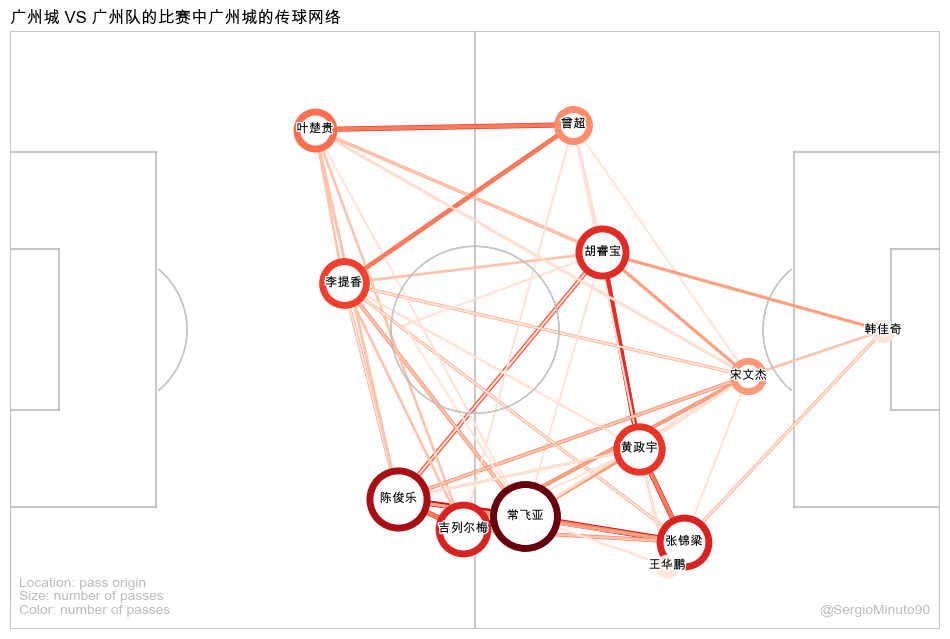

In [223]:
from visualization.passing_network import draw_pitch, draw_pass_map
import matplotlib.pyplot as plt
plt.rcParams["font.sans-serif"]=["SimHei"] #设置字体
plt.rcParams["axes.unicode_minus"]=False #该语句解决图像中的“-”负号的乱码问题
plot_title ="广州城 VS 广州队的比赛中广州城的传球网络"

plot_legend = "Location: pass origin\nSize: number of passes\nColor: number of passes"


ax = draw_pitch()
ax = draw_pass_map(ax, player_position, player_pass_count, player_pass_value,
              pair_pass_count, pair_pass_value, plot_title, plot_legend)

# plt.savefig("demo/{0}.png".format(plot_name))